In [60]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

In [70]:
keras.backend.image_data_format()

'channels_last'

In [81]:
keras.backend.set_image_data_format("channels_first")

In [82]:
import cv2

In [83]:
latent_dim = 100

In [84]:
(X_train, y_train),( X_test, y_test) = mnist.load_data()


In [85]:
X_train.shape

(60000, 28, 28)

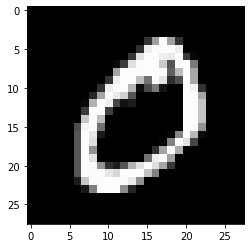

In [86]:
img = cv2.cvtColor(X_train[1],cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [87]:
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]

In [88]:
adam = Adam(lr=0.0002, beta_1=0.5)

In [95]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=latent_dim))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2,2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

In [96]:
generator.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_19 (Reshape)         (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_25 (UpSampling (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 64, 14, 14)        0         
_________________________________________________________________
up_sampling2d_26 (UpSampling (None, 64, 28, 28)      

In [98]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                         input_shape=(1, 28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)


In [99]:
discriminator.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 64, 14, 14)        1664      
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 64, 14, 14)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 7, 7)         204928    
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 128, 7, 7)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 7, 7)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)            

In [100]:
discriminator.trainable = False

In [102]:
ganInput = Input(shape=(latent_dim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)


In [103]:
dLosses = []
gLosses = []

In [104]:
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [105]:
def plotGeneratedImages(epoch, examples=10, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()

In [107]:
epochs = 5
batchSize = 128
batchCount = X_train.shape[0] / batchSize

In [108]:
for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for i in tqdm(range(int(batchCount))):
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

        # Generate fake MNIST images
        generatedImages = generator.predict(noise)
        X = np.concatenate([imageBatch, generatedImages])

        # Labels for generated and real data
        yDis = np.zeros(2*batchSize)
        # One-sided label smoothing
        yDis[:batchSize] = 0.9

        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)

        # Train generator
        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        yGen = np.ones(batchSize)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)
 
    dLosses.append(dloss)
    gLosses.append(gloss)

    if e == 1 or e % 5 == 0:
        plotGeneratedImages(e)
        plotLoss(e)

--------------- Epoch 1 ---------------


  0%|▏                                                                               | 1/468 [00:13<1:44:42, 13.45s/it]

FailedPreconditionError:  Error while reading resource variable _AnonymousVar114 from Container: localhost. This could mean that the variable was uninitialized. Not found: Resource localhost/_AnonymousVar114/class tensorflow::Var does not exist.
	 [[node mul_26/ReadVariableOp (defined at C:\Users\iamuraptha\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_keras_scratch_graph_3602]

Function call stack:
keras_scratch_graph
